<a href="https://colab.research.google.com/github/zyazam/Machine_Learning_Project/blob/main/Version(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


# ***Welcome To The Machine Learning (1) Project***

***What we are trying to do in this project is to apply everything we learned in the machine learning course, from analyzing, cleaning, and processing data to applying machine learning algorithms.***

## And of course, we will use this dataset [**Dataset**](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis) to practice sorcery on it.


## ***We will do our best to carry out all the required tasks..***

## **The students in charge of this project:**
- ***Hamza Mu'in Rashid Issa***
- ***Zaid Yusef GH. Hashash***



---






---




- In the first cell, we will import the libraries used in the project.

In [ ]:
import pandas as pd
import numpy as np
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold

- Download data directly from Kaggle, via **API Token**

  -**(google.colab files)**
  This is the library used to upload API tokens

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/instacart-market-basket-analysis/products.csv
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv
/kaggle/input/instacart-market-basket-analysis/orders.csv
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv
/kaggle/input/instacart-market-basket-analysis/aisles.csv
/kaggle/input/instacart-market-basket-analysis/departments.csv


In [ ]:
Types = {
    'aisle_id': 'int32',
    'aisle': 'category',
    'order_id': 'int32',
    'user_id': 'int32',
    'eval_set': 'category',
    'order_number': 'int32',
    'order_dow': 'int32',
    'order_hour_of_day': 'int32',
    'days_since_prior_order': 'float16',
    'department_id': 'int8',
    'department': 'category',
    'product_id': 'int32',
    'product_name': 'category',
    'add_to_cart_order': 'int32',
    'reordered': 'int8',
}


# Reading files using enhanced data types
aisles = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/aisles.csv', dtype={i: Types.get(i, None) for i in ['aisle_id','aisle']})

departments = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/departments.csv', dtype={i: Types.get(i, None) for i in ['department_id','department']})

products = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/products.csv', dtype={i: Types.get(i, None) for i in ['product_id', 'aisle_id', 'department_id',' product_name']})

# Read orders, excluding 'days_since_prior_order' from explicit dtype setting during read_csv
orders = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/orders.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day','eval_set']})
# Convert 'days_since_prior_order' to float16 after loading the DataFrame
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')

order_products_prior = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'product_id', 'add_to_cart_order', 'reordered']})


In [ ]:
print(aisles.info())
print("------------------------------------------------")
print(orders.info())
print("------------------------------------------------")
print(departments.info())
print("------------------------------------------------")
print(products.info())
print("------------------------------------------------")
print(order_products_prior.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int32   
 1   aisle     134 non-null    category
dtypes: category(1), int32(1)
memory usage: 6.0 KB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
dtypes: category(1), float16(1), int32(5)
memory usage: 75.0 MB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entrie

In [ ]:
My_Data = pd.merge(orders, order_products_prior,how = 'left', on='order_id')
My_Data = pd.merge(My_Data, products,how = 'left', on='product_id')
My_Data = pd.merge(My_Data, aisles,how = 'left', on='aisle_id')
My_Data = pd.merge(My_Data, departments,how = 'left', on='department_id')
My_Data.head()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household


In [ ]:
My_Data['product_name'] = My_Data['product_name'].astype('category')

In [ ]:
print(My_Data.shape)
print("-----------------------------")
print(My_Data.info())

(32640698, 15)
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
 7   product_id              float64 
 8   add_to_cart_order       float64 
 9   reordered               float64 
 10  product_name            category
 11  aisle_id                float64 
 12  department_id           float64 
 13  aisle                   category
 14  department              category
dtypes: category(4), float16(1), float64(5), int32(5)
memory usage: 2.1 GB
None


# **• Missing value analysis and visualization**

In [ ]:
missing_data = My_Data.isnull().sum()
print(missing_data)

print("-------------------------------")
missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
print(missing_percentage)

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_id                 206209
add_to_cart_order          206209
reordered                  206209
product_name               206209
aisle_id                   206209
department_id              206209
aisle                      206209
department                 206209
dtype: int64
-------------------------------
order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.366494
product_id                0.631754
add_to_cart_order         0.631754
reordered                 0.631754
product_name              0.631754
aisle_id                  0.631754
department_id            

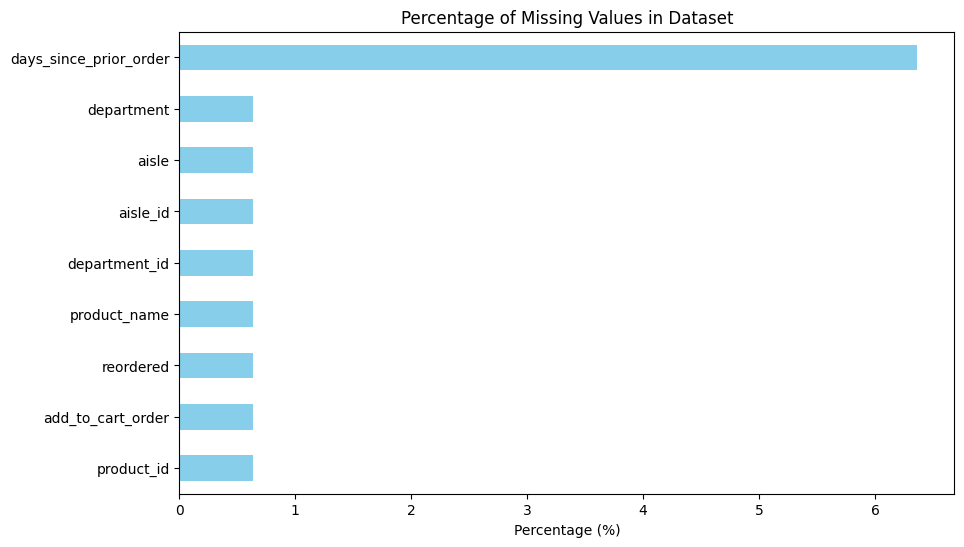

In [ ]:
missing_percentage = missing_percentage[missing_percentage > 0]

if not missing_percentage.empty:
    missing_percentage.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
    plt.title('Percentage of Missing Values in Dataset')
    plt.xlabel('Percentage (%)')
    plt.show()
else:
  print("There are not missing values")

## **We will process missing values ​​directly to reduce memory usage.**

-  ***Since these are missing values ​​due to the lack of matching records in other tables, we will use a fixed-value compensation method.***

In [ ]:
# Text column processing
for col in ['product_name', 'aisle', 'department']:
    if My_Data[col].dtype.name == 'category' and 'Unknown' not in My_Data[col].cat.categories:
        My_Data[col] = My_Data[col].cat.add_categories(['Unknown'])
    My_Data[col] = My_Data[col].fillna('Unknown')

# Processing numerical columns
for col in ['product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'reordered']:
    My_Data[col] = My_Data[col].fillna(-1).astype('int32')

-  Now, let's address the missing values ​​from the column (days_since_prior_order)

In [ ]:
My_Data['days_since_prior_order'] = My_Data['days_since_prior_order'].fillna(-1)

In [ ]:
missing_data = My_Data.isnull().sum()
print(missing_data)

print("-------------------------------")
missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
print(missing_percentage)

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64
-------------------------------
order_id                  0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
product_name              0.0
aisle_id                  0.0
department_id             0.0
aisle                     0.0
department                0.0
dtype: float64




---


# **• Distribution plots for numeric features and target(s) (histogram, density).**

### ***-  These six columns were chosen because they encompass the three fundamental dimensions of any recommendation system: time (hour and day of order), behavior (number of orders and basket order), and periodicity (days since the last order). These columns are the most correlated with the target variable (reordered).***

-   **Determine peak activity**

     The diagram shows that activity starts to rise from 7 am and reaches its peak between 10 am and 4 pm.

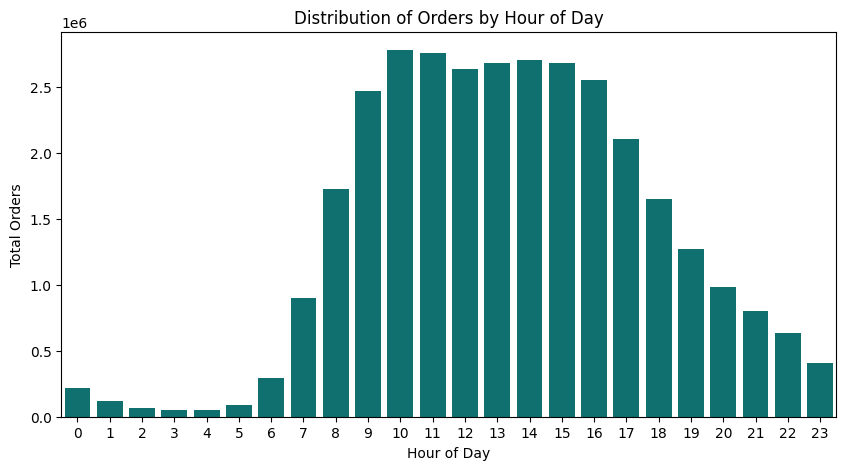

In [ ]:
hourly_dist = My_Data['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_dist.index, y=hourly_dist.values, color='teal')
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Orders')
plt.show()

-  **Distribution of days of the week**

    The distribution of orders across the days of the week (from 0 to 6) shows that Saturday and Sunday are the most active days.

/tmp/ipykernel_290/1164475255.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_dist.index, y=dow_dist.values, palette='viridis')


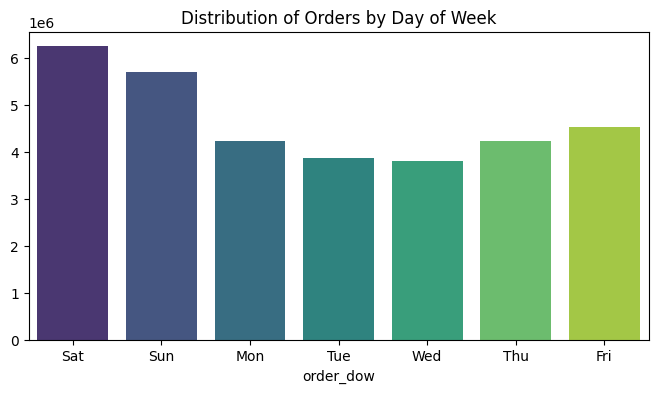

In [ ]:
dow_dist = My_Data['order_dow'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=dow_dist.index, y=dow_dist.values, palette='viridis')
plt.title('Distribution of Orders by Day of Week')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sat','Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.show()

-  Distribution of days since the last request

    This graph (Density Plot) shows when customers will return to buy again. We notice two clear peaks; one at 7 days and another very sharp one at 30 days.

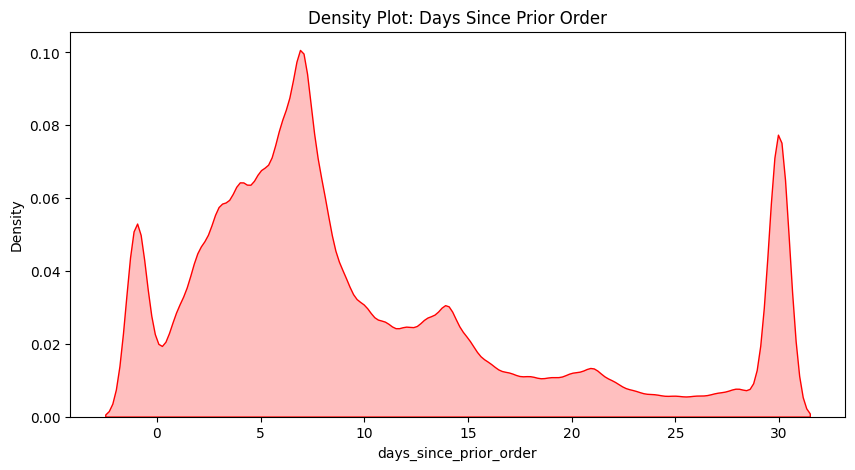

In [ ]:
sample_data = My_Data['days_since_prior_order'].dropna().sample(2000000)

plt.figure(figsize=(10, 5))
sns.kdeplot(sample_data, fill=True, color="r")
plt.title('Density Plot: Days Since Prior Order')
plt.show()

-  **Order of adding products to the cart**

    The probability of a product being the first, second, or tenth item in the shopping cart is shown; the vast majority of products are added to the first five positions (1 to 5), and the higher the position, the fewer the number.

    - Because the dataset exceeds 32 million records, plotting the Key Density Curve (KDE) requires immense processing power. I used a random sample of 2 million records to ensure accurate representation of the statistical distribution while maintaining performance efficiency and processing speed.

    - The value (-1) was used as the Sentinel Value to represent initial requests that contained missing values. Having this value appear separately in the Distribution Plot ensures that new user data is not mixed with that of repeat users, and prevents the model from being biased towards average values ​​such as 7 or 8 days.

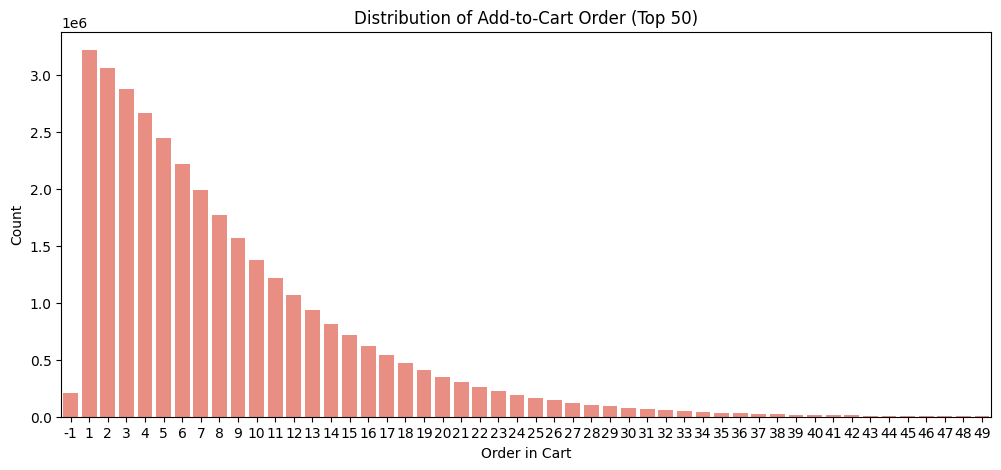

In [ ]:
cart_dist = My_Data['add_to_cart_order'].value_counts().head(50)

plt.figure(figsize=(12, 5))
sns.barplot(x=cart_dist.index, y=cart_dist.values, color='salmon')
plt.title('Distribution of Add-to-Cart Order (Top 50)')
plt.xlabel('Order in Cart')
plt.ylabel('Count')
plt.show()

-  **Customer loyalty**

    The distribution of the number of requests per user is shown. The distribution is right-skewed, as most users have a small number of requests, while the number gradually decreases for "loyal" users who have requested more than 50 times.

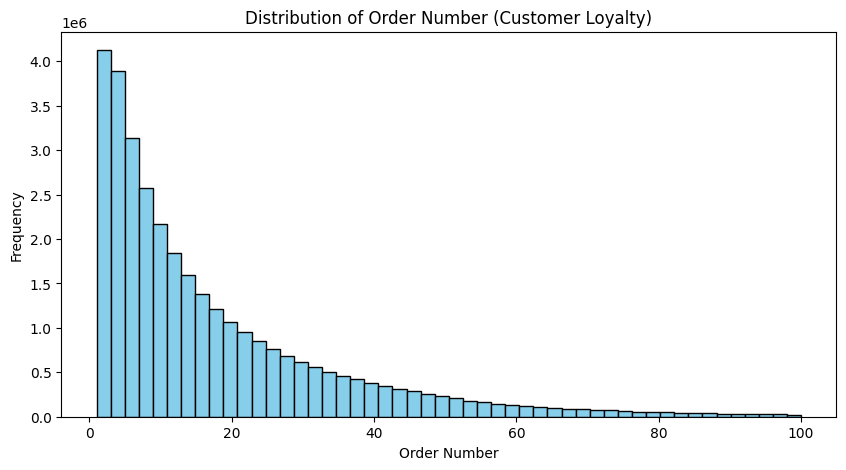

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(My_Data['order_number'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Order Number (Customer Loyalty)')
plt.xlabel('Order Number')
plt.ylabel('Frequency')
plt.show()

-  **Target variable**

    The graph shows the ratio of products that are repurchased versus those that are purchased for the first time.

# **• Categorical cardinality analysis (barplots / top-k frequencies)**

-  We focused on analyzing aisles and sections because they represent structural levels of data. Analyzing them allows us to understand the distribution of purchasing power and identify the categories that dominate transaction volume, which helps simplify the model's feature engineering and ensures its ability to differentiate between fast-moving consumer goods and seasonal goods.

-  **Focus on the most impactful corridors**

    Analysis of all aisles reveals that the Fresh Fruits aisle leads the list with exceptional purchasing volume. This indicates that repurchase decisions in this project are directly influenced by perishable goods, justifying the focus on short-term (7-day) order fulfillment patterns.

/tmp/ipykernel_290/2957157686.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


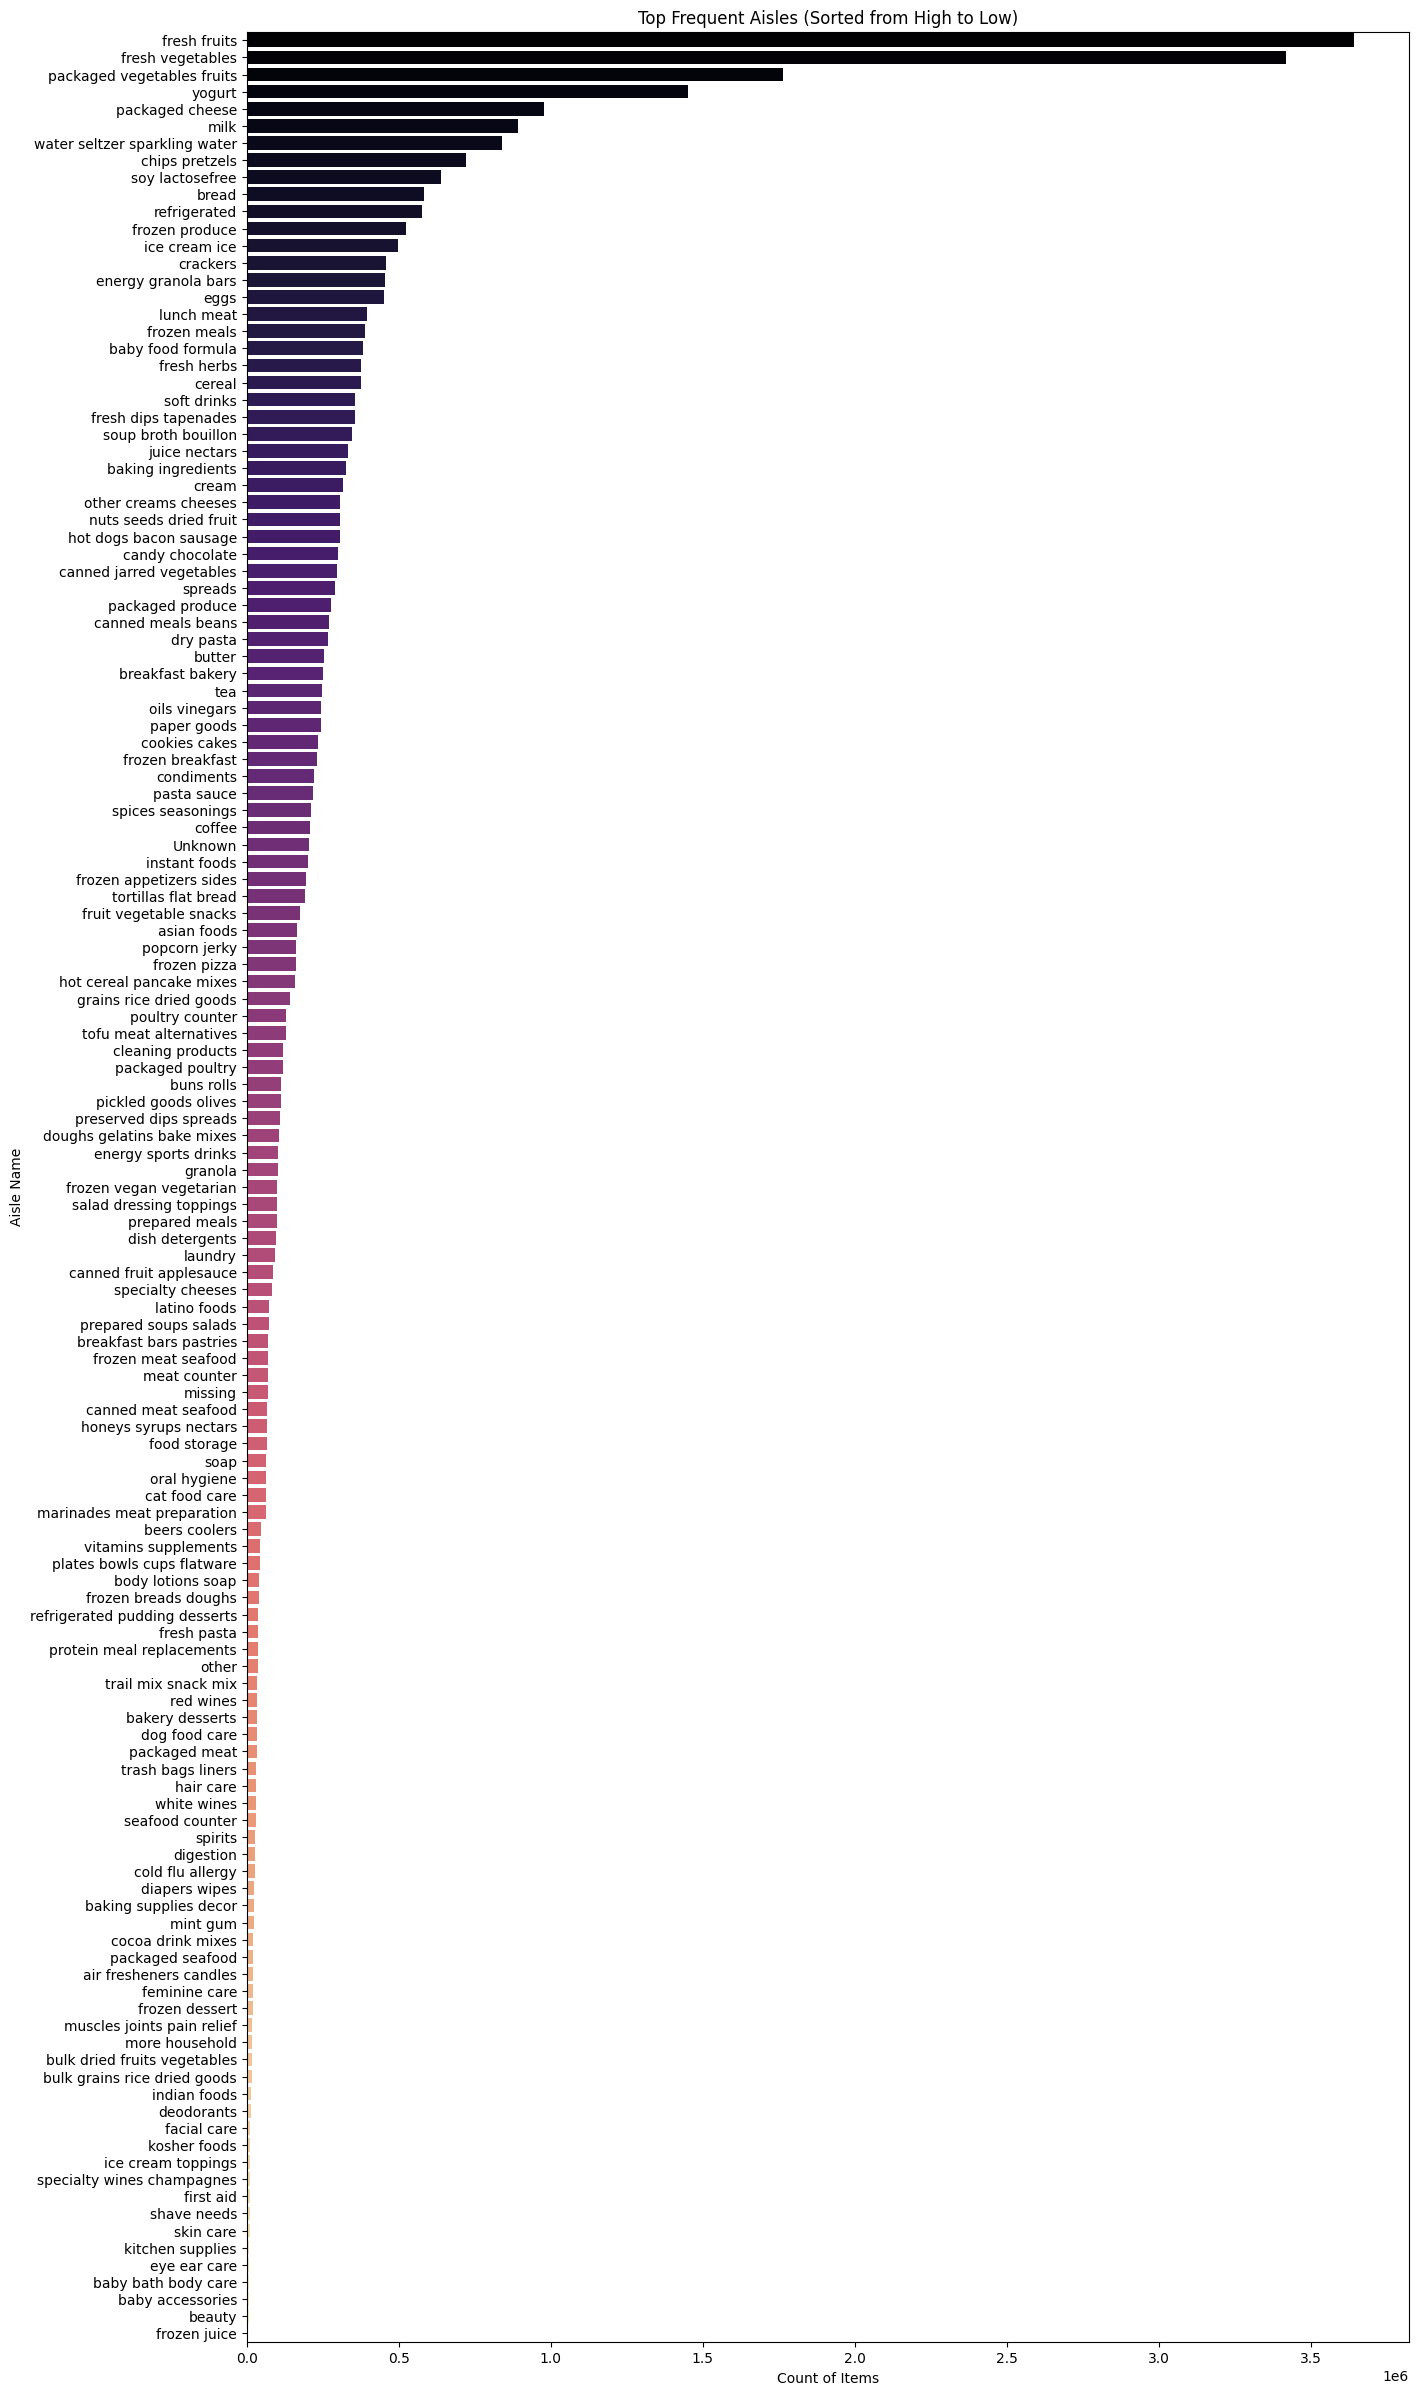

In [ ]:
top_aisles = My_Data['aisle'].value_counts()

plt.figure(figsize=(15, 30))

sns.barplot(
    x=top_aisles.values,
    y=top_aisles.index,
    order=top_aisles.index,
    palette='magma'
)

plt.title('Top Frequent Aisles (Sorted from High to Low)')
plt.xlabel('Count of Items')
plt.ylabel('Aisle Name')
plt.show()

- We moved from detailed aisle analysis to departmental analysis to gain a comprehensive strategic perspective. The results showed that the Produce department represented the largest weight in the data, reinforcing our hypothesis that repurchase behavior is closely linked to fresh, everyday produce.

/tmp/ipykernel_290/1273000993.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


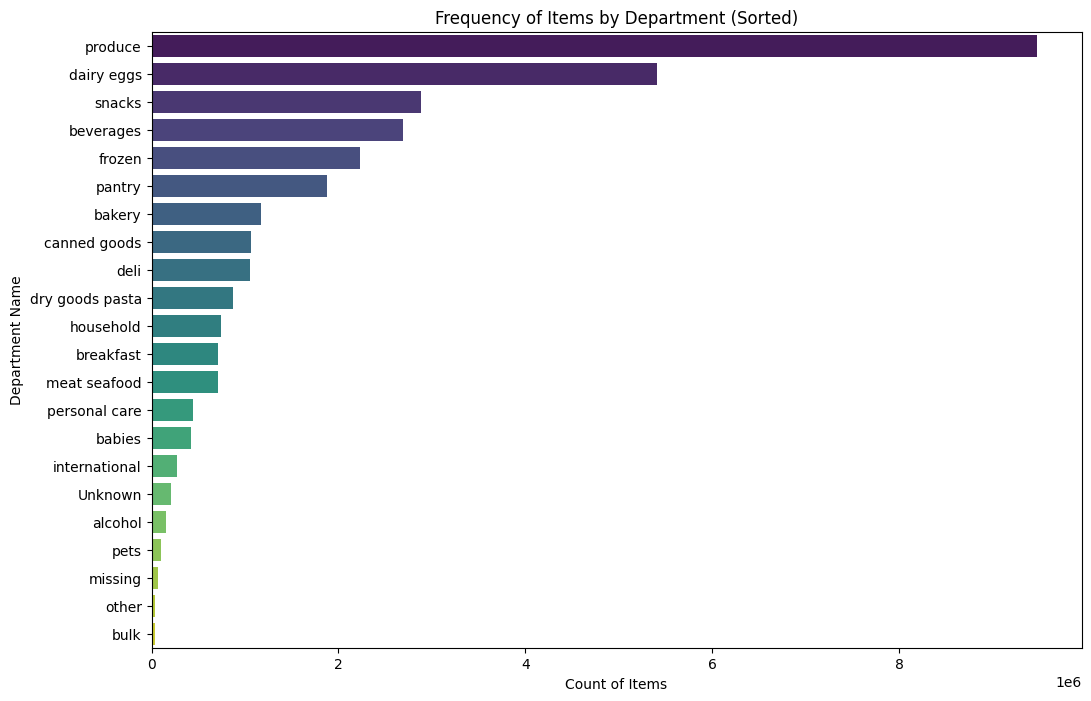

In [ ]:
dept_counts = My_Data['department'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(
    x=dept_counts.values,
    y=dept_counts.index,
    order=dept_counts.index,
    palette='viridis'
)

plt.title('Frequency of Items by Department (Sorted)')
plt.xlabel('Count of Items')
plt.ylabel('Department Name')
plt.show()

-  I performed a **categorical cardinality** analysis using a logarithmic scale to understand the diversity of the textual data. This analysis is essential for selecting the appropriate encoding strategy for each variable; it showed that the products column has high cardinality and requires special processing, while sections and corridors represent a balanced classification level from which the model can learn effectively without excessive memory consumption.

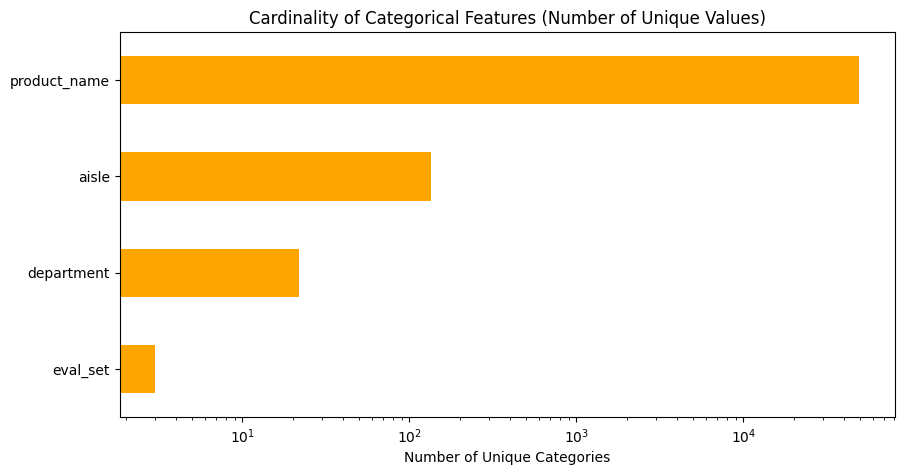

In [ ]:
categorical_cols = ['aisle', 'department', 'product_name', 'eval_set']
cardinality = My_Data[categorical_cols].nunique().sort_values()

plt.figure(figsize=(10, 5))
cardinality.plot(kind='barh', color='orange')
plt.title('Cardinality of Categorical Features (Number of Unique Values)')
plt.xlabel('Number of Unique Categories')
plt.xscale('log')
plt.show()

# **Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.**

-  **Correlation Matrix / Heatmap**

    This graph tells us how strong the relationship is between any two variables with a number between (-1 and 1).

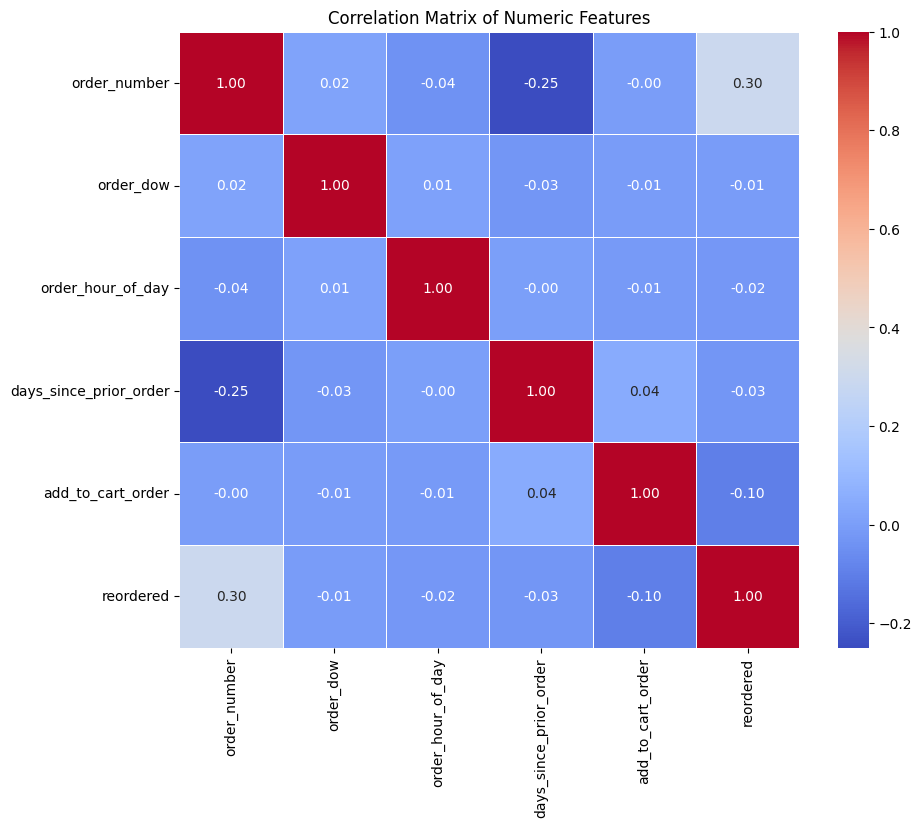

In [ ]:
numeric_cols = ['order_number', 'order_dow', 'order_hour_of_day',
                'days_since_prior_order', 'add_to_cart_order', 'reordered']

corr_matrix = My_Data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

-  **Pairwise Scatter Plots**

    A sample of 50,000 records was used because plotting a pairwise array requires extremely intensive computations that memory cannot handle with such a large dataset. Furthermore, plotting millions of points leads to overplotting, which obscures the details of class distribution, whereas a random sample provides an ideal balance between statistical accuracy and visual clarity.

    **What do the three colors mean?**
    
    - Dark color (1): Represents **reordered** products
    - Medium color (0): Represents **new products** purchased for the first time
    - Very light color (-1): Represents the **first orders for new users** (First Orders)

-  I developed the dual-color graph to include three color categories instead of two. This allowed us to clearly distinguish the initial requests (represented by the value -1). Through this graph, we demonstrated that the data from new users is completely isolated and does not cause any interference with the reorder patterns of existing users, thus improving the quality of the data input to the machine learning model.

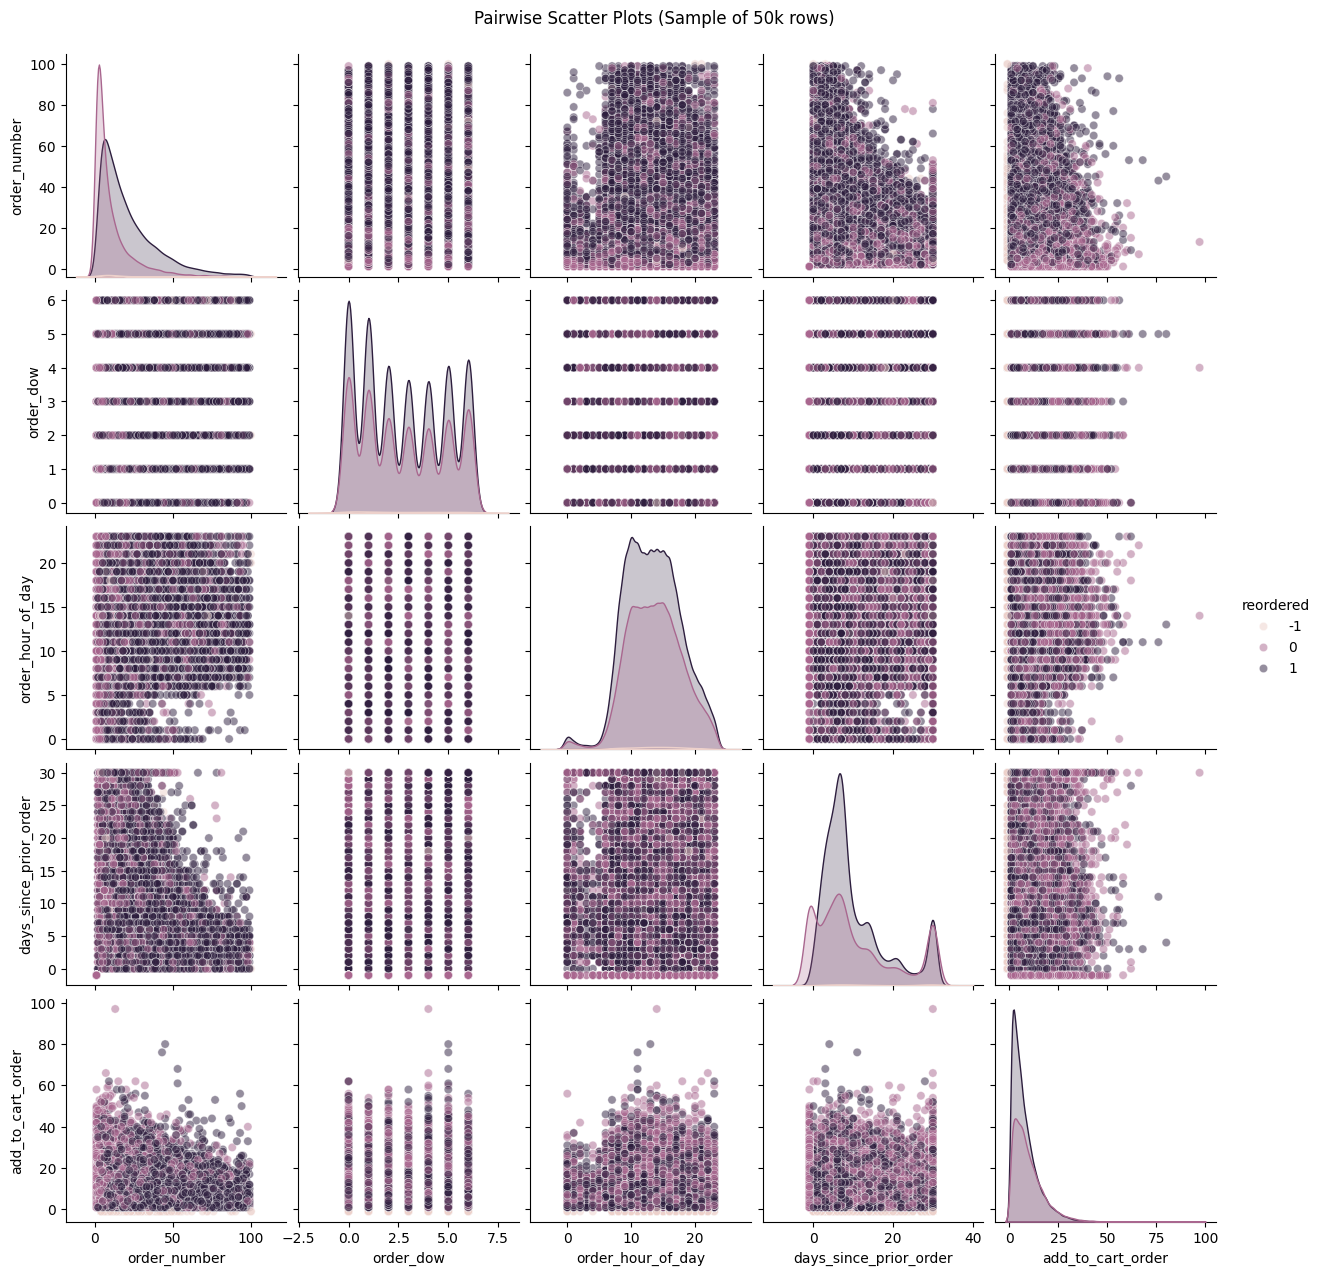

In [ ]:
data_sample = My_Data[numeric_cols].sample(50000)
sns.pairplot(data_sample, hue='reordered', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Scatter Plots (Sample of 50k rows)', y=1.02)
plt.show()

# **• Time-of-day, day-of-week, and monthly seasonality plots.**

- ##  We analyzed the seasonality of the time period to uncover purchasing cycles. The results showed a significant concentration of orders at the beginning of the week and during daylight hours (10:00 to 16:00). These time patterns provide important context for the model, as peak times are typically associated with 'stocking up' orders, which are characterized by high reorder rates.

- ##  We did not plot monthly seasonality because the Instacart dataset does not provide absolute calendar dates (timestamps), but rather relative time data focusing on the day of the week and hour of the day. Instead, we relied on days_since_prior_order analysis to uncover monthly patterns in repurchase behavior, with the results showing a clear peak at 30 days, representing the customers' monthly shopping cycle.

- **Daily Seasonality**

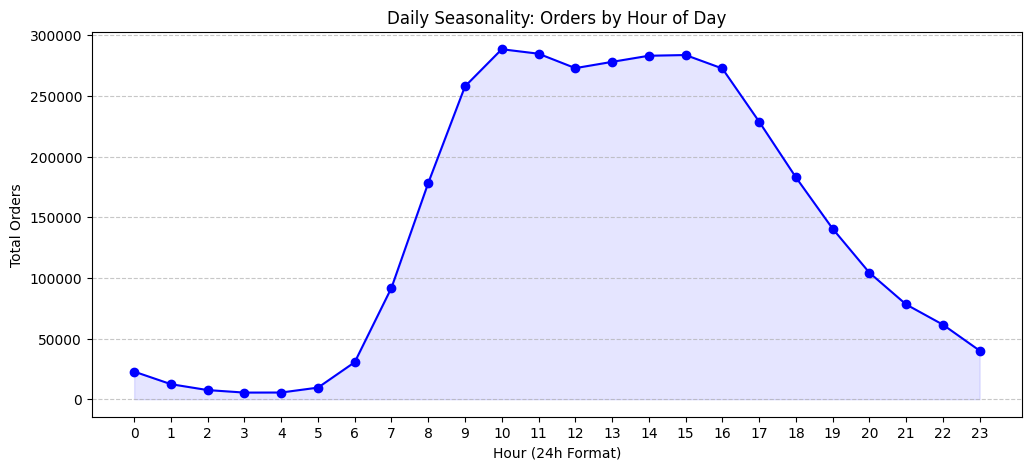

In [ ]:
hourly_season = My_Data.groupby('order_hour_of_day')['order_id'].nunique()

plt.figure(figsize=(12, 5))
plt.plot(hourly_season.index, hourly_season.values, marker='o', linestyle='-', color='b')
plt.fill_between(hourly_season.index, hourly_season.values, alpha=0.1, color='b')
plt.title('Daily Seasonality: Orders by Hour of Day')
plt.xlabel('Hour (24h Format)')
plt.ylabel('Total Orders')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.show()

- **Weekly Seasonality**

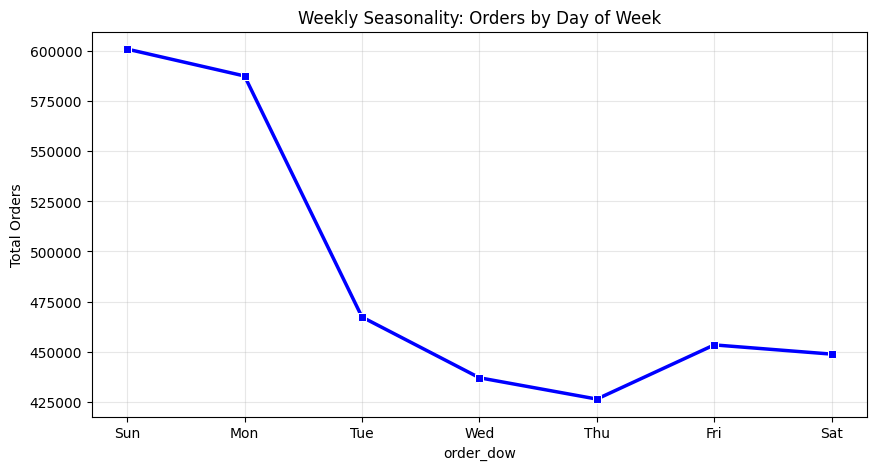

In [ ]:
weekly_season = My_Data.groupby('order_dow')['order_id'].nunique()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_season.index, y=weekly_season.values, marker='s', color='b', linewidth=2.5)
plt.title('Weekly Seasonality: Orders by Day of Week')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Total Orders')
plt.grid(True, alpha=0.3)
plt.show()

- # *Outlier detection & treatment (winsorizing or removal with justification)*

-  ### We limited the analysis of outliers to these three variables because they represent the quantitative behavioral features of customers. As continuous variables, they are the most susceptible to statistical dispersion, which can skew the predictive model. The remaining columns are either categorical or time-bound, confined to a fixed range, and do not require outlier analysis

-  A comprehensive ****digital audit**** was performed on the entire dataset. Using the ****Interquartile Range (IQR) equation****, we successfully determined the precise number and percentage of outliers for each behavioral variable. This digital audit validated the visual observations in the ****box plots**** .

In [ ]:
# before
cols_to_check = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

print("--- Digital Outlier Detection Report---")

for col in cols_to_check:
    Q1 = My_Data[col].quantile(0.25)
    Q3 = My_Data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = My_Data[(My_Data[col] < lower_bound) | (My_Data[col] > upper_bound)]
    count = outliers.shape[0]
    percentage = (count / len(My_Data)) * 100

    print(f"\nColomen: {col}")
    print(f"Max {upper_bound}")
    print(f"Number Of outliers: {count:,}")
    print(f"Percentage of outliers: {percentage:.2f}%")

--- Digital Outlier Detection Report---

Colomen: order_number
Max 52.5
Number Of outliers: 1,793,629
Percentage of outliers: 5.50%

Colomen: add_to_cart_order
Max 23.0
Number Of outliers: 1,357,124
Percentage of outliers: 4.16%

Colomen: days_since_prior_order
Max 29.0
Number Of outliers: 3,133,243
Percentage of outliers: 9.60%


-  This step was not merely a drawing, but an ****auditing process****; we proved numerically and visually that the outliers were not just random errors, but extreme values ​​representing a significant percentage (up to 5.5%), making the decision to address them using ****Winsorization**** a decision based on strong statistical evidence to ensure the model's stability later on.

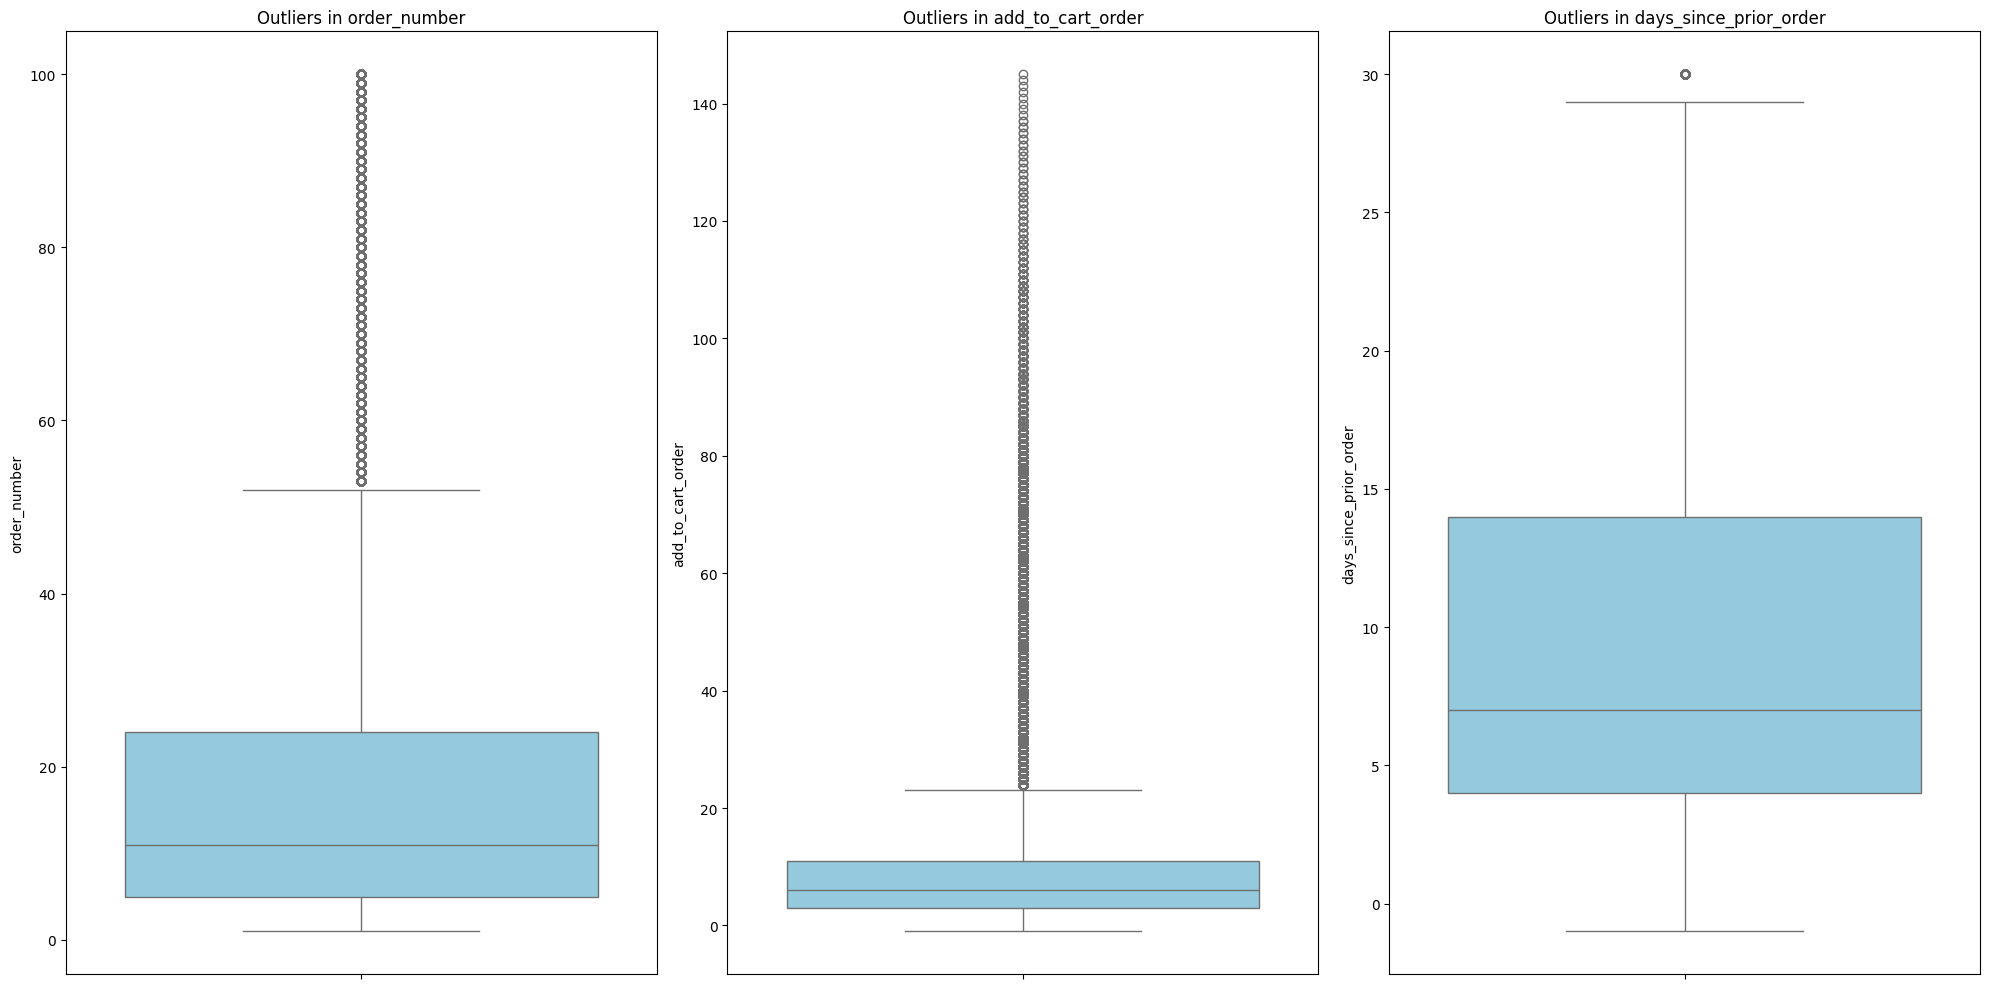

In [ ]:
cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

plt.figure(figsize=(20, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=My_Data[col], color='skyblue')
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

-  We ruled out the removal option because we are dealing with a massive database, and deleting outliers would result in the loss of over 1.7 million records, potentially preventing the model from understanding the behavior of its most active customers. Instead, we opted for Winsorizing to address statistical outliers by restricting them to the 99th percentile. This decision ensures data integrity and provides a stable training environment for the predictive model without sacrificing sample size.

-  I experimented with the 99th and 95th percentiles and found that 0.95 was the most suitable for our project. This is because Instacart data exhibits very high dispersion in purchasing behavior, and the 95th percentile more closely aligns with the statistical IQR limits we previously calculated. This ensures a reduction in standard deviation and the fitting of more homogeneous features, which helps the algorithm learn more quickly and accurately.

In [ ]:
cols_to_fix = ['order_number', 'add_to_cart_order', 'days_since_prior_order']
for col in cols_to_fix:
    upper_limit = My_Data[col].quantile(0.95)
    My_Data[col] = np.where(My_Data[col] > upper_limit, upper_limit, My_Data[col])

    print(f"Done: {col} | New Max Limit: {upper_limit}")

Done: order_number | New Max Limit: 54.0
Done: add_to_cart_order | New Max Limit: 22.0
Done: days_since_prior_order | New Max Limit: 30.0


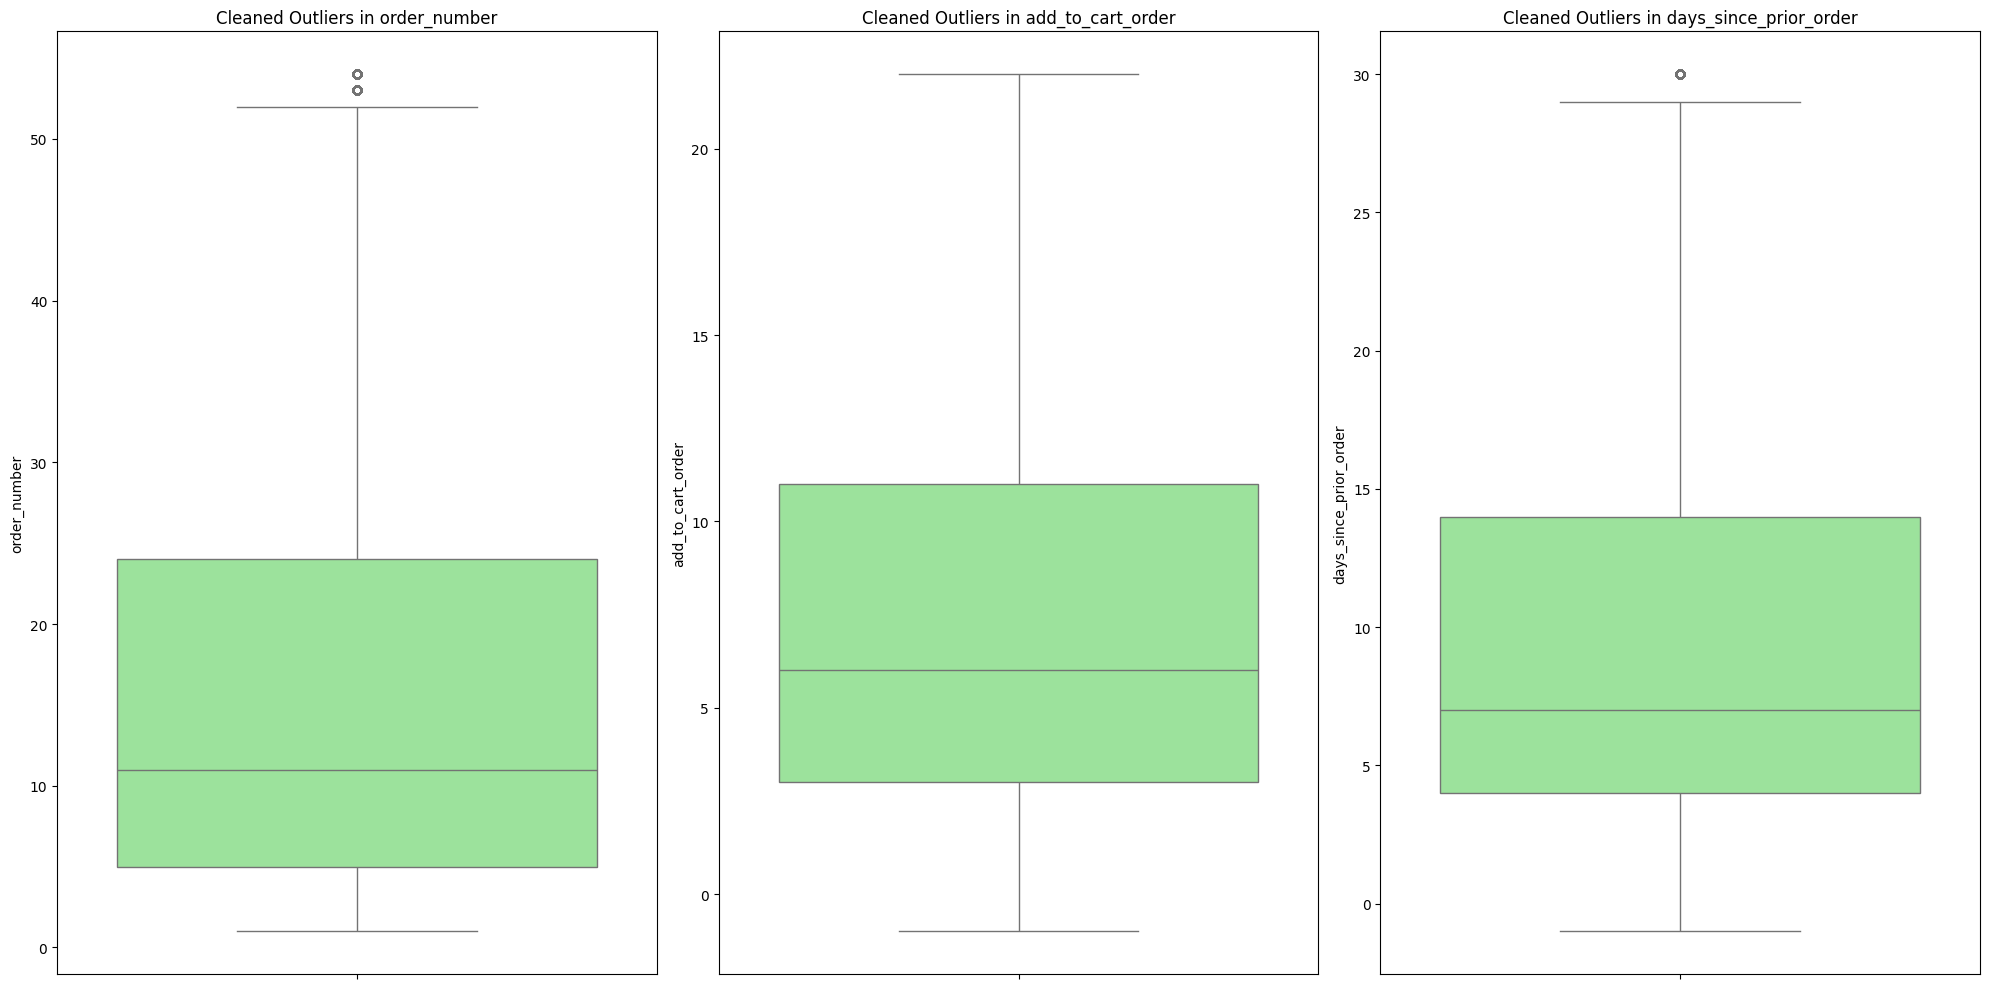

In [ ]:
cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

plt.figure(figsize=(20, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=My_Data[col], color='lightgreen')
    plt.title(f'Cleaned Outliers in {col}')

plt.tight_layout()
plt.show()

- # Encoding Categorical Variables


In [ ]:
encoding_stats = My_Data[['eval_set','product_name','product_id', 'user_id', 'aisle_id', 'department_id', 'order_dow', 'order_hour_of_day']].nunique()

print("--- Cardinality Report ---")
print(encoding_stats)

--- Cardinality Report ---
eval_set                  3
product_name          49678
product_id            49678
user_id              206209
aisle_id                135
department_id            22
order_dow                 7
order_hour_of_day        24
dtype: int64


- ## **One-Hot Encoding**
  - ***Low-cardinality columns were chosen to ensure that the data dimensions did not become so large as to hinder processing.***
  - ***(eval_set)*** : Convert from one column to two columns (because the original had 3 categories)
  - ***(order_dow)*** : Convert to 6 columns (because the original had 7 categories)
  - ***(department_id)*** : Convert to 21 columns (because the original had 22 categories)
  - ***(order_hour_of_day)*** : Convert to 23 columns (because the original had 24 categories)

In [ ]:
low_card_cols = ['eval_set', 'order_dow', 'department_id', 'order_hour_of_day']
My_Data = pd.get_dummies(My_Data, columns=low_card_cols, drop_first=True, dtype='int8')

cols_to_drop = ['department', 'aisle', 'aisle_id']
My_Data.drop(columns=['department', 'aisle'], inplace=True, errors='ignore')

print("Done! One-Hot Encoding complete.")
print(f"New shape: {My_Data.shape}")

KeyError: "None of [Index(['eval_set', 'order_dow', 'department_id', 'order_hour_of_day'], dtype='object')] are in the [columns]"

In [ ]:
print( {My_Data.shape})

{(32640698, 61)}


- ## **Target Encoding**
   -  ***The columns were selected because they contained thousands of unique values ​​that could not be processed using One-Hot Encoding.***
   -  ***(product_id) , (user_id) , (aisle_id)***
   -  The target columns were transformed from random integers to fractional floats, often ranging between 0 and 1. These values ​​accurately represent the "reorder probability" for each product and each user, making the model able to distinguish between "highly requested" and "passing" products with great ease.

In [ ]:
high_card_cols = ['product_id', 'user_id', 'aisle_id']

te = TargetEncoder(cols=high_card_cols, smoothing=10)
My_Data[high_card_cols] = te.fit_transform(My_Data[high_card_cols], My_Data['reordered'])

print(My_Data[high_card_cols].head())

   product_id   user_id  aisle_id
0    0.776480  0.665102  0.638832
1    0.810982  0.665102  0.692551
2    0.740735  0.665102  0.591986
3    0.539041  0.665102  0.591986
4    0.441516  0.665102  0.528005


- ## **Frequency encoding**
- ***Frequency encoding was chosen to represent the product_name column because it adds a new statistical feature to the model: product popularity. Unlike hashing tricks, which produce random values ​​that may suffer collisions, frequency encoding provides a logical relationship between the number of times a product appears and the probability of it being repurchased, thus improving prediction accuracy while maintaining memory efficiency.***
- Converting long text names into numerical values ​​that express the "weight" or "popularity" of a category helps the model understand patterns associated with bestsellers.

In [ ]:
product_counts = My_Data['product_name'].value_counts()

My_Data['product_name'] = My_Data['product_name'].map(product_counts)
print(My_Data[['product_name']].head())

   product_name
0         35791
1         15935
2          6476
3          2523
4          1214


In [ ]:
print(My_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 61 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   user_id                 float64
 2   order_number            float64
 3   days_since_prior_order  float64
 4   product_id              float64
 5   add_to_cart_order       float64
 6   reordered               int32  
 7   product_name            int64  
 8   aisle_id                float64
 9   eval_set_test           int8   
 10  eval_set_train          int8   
 11  order_dow_1             int8   
 12  order_dow_2             int8   
 13  order_dow_3             int8   
 14  order_dow_4             int8   
 15  order_dow_5             int8   
 16  order_dow_6             int8   
 17  department_id_1         int8   
 18  department_id_2         int8   
 19  department_id_3         int8   
 20  department_id_4         int8   
 21  department_id_5         int8 